# Single-phase flow in PorePy
In this tutorial we investigate how to solve single-phase flow in **PorePy**. <br>
We consider
* two-point flux approximation
* multi-point flux approximation
* dual virtual element method
* hybrid-dual virtual element method

**Note**: This tutorial will focus on a 2d domain, however most of the code works for 1d, 2d, and 3d domains.<br>

Let is $\Omega$ a regular domain with boundary $\partial \Omega$. The boundary can be divided in two non-overlapping parts useful to impose Dirichlet ($\partial \Omega_d$) and Neumann ($\partial \Omega_n$) boundary conditions. We indicate with $\mathbf{n}$ the outward unit normal vector of $\partial \Omega$.<br>
The single-phase flow can be written in
* dual formulation as:
$$\nabla \cdot \mathbf{u} = f \\ \mathbf{u} = - K \nabla p$$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \\ \mathbf{u} \cdot \mathbf{n} = u_b$$
* primal formulation as:
$$ - \nabla \cdot K \nabla p = f $$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \\ - K \nabla p \cdot \mathbf{n} = u_b$$

Where $f$ is a scalar source/sink term, $K$ is the permeability matrix, $p_b$ is the pressure at the boundary (Dirichlet condition), and $u_p$ is the flux at the boundary (Neumann condition).<br>

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem. <br><br>

For the example we assume: $\Omega$ as presented below, $\partial \Omega_d = \partial \Omega$, $\partial \Omega_n = \emptyset$, with data: $f = 1$, $K = I$, and $p_b = 0$.

## Import modules
Before creating the grid we import some modules.

In [1]:
import numpy as np
import scipy.sparse as sps

from porepy.grids import structured
from porepy.viz import plot_grid
from porepy.params import second_order_tensor, bc

from porepy.utils import comp_geom

## Creation of the grid
We create a distorted Cartesian grid and compute its geometry.

In [2]:
Nx = Ny = 20                                          
g = structured.CartGrid([Nx, Ny], [2, 2])
g.nodes[0, :] = g.nodes[0, :] - 1
g.nodes[1, :] = g.nodes[1, :] - 1

def dist(n): return np.dot(comp_geom.rot(np.linalg.norm(n), [0, 0, 1]), n)
g.nodes = np.apply_along_axis(dist, 0, g.nodes)

g.compute_geometry()

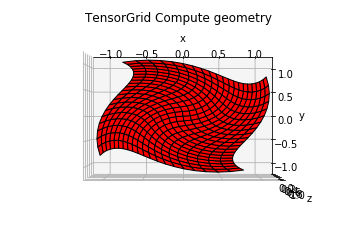

In [3]:
plot_grid.plot_grid(g, figsize=(12, 8))

# Problem data
We declare the permability matrix $K$, the scalar source term $f$, and the boundary conditions

In [6]:
# Permeability
perm = second_order_tensor.SecondOrderTensor(g.dim, np.ones(g.num_cells))                     

# Scalar source
f = np.ones(g.num_cells)

# Boundary conditions
b_faces = g.get_boundary_faces()
bnd = bc.BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
bnd_val = np.zeros(g.num_faces)

Once all the data are created we group them in a dictionary

In [7]:
data = {'k': perm, 'f': f, 'bc': bnd, 'bc_val': bnd_val}

## Problem solution
In this section we present all the approaches to solve the problem.<br>
**Note**: The problem data are not stored in the solver class.
### Two-point flux approximation
The two-point flux approximation solves the single-phase flow problem in the primal formulation. The pressure is directly computed.

In [8]:
from porepy.numerics.fv import tpfa

solver = tpfa.Tpfa()
A, b = solver.matrix_rhs(g, data)
p = sps.linalg.spsolve(A, b) 

To represent the solution.

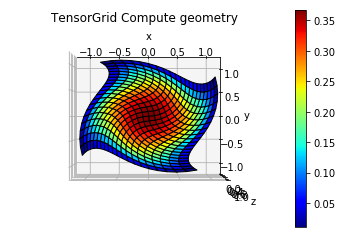

In [9]:
plot_grid.plot_grid(g, p, figsize=(12, 8))

### Multi-point flux approximation 
The multi-point flux approximation solves the single-phase flow problem in the primal formulation. The pressure is directly computed.

In [10]:
from porepy.numerics.fv import mpfa

solver = mpfa.Mpfa()
A, b = solver.matrix_rhs(g, data)
p = sps.linalg.spsolve(A, b)

To represent the solution.

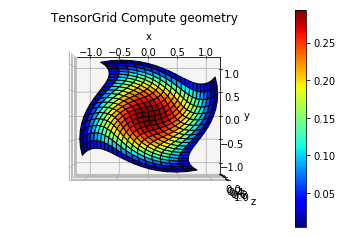

In [11]:
plot_grid.plot_grid(g, p, figsize=(12, 8))

### Dual virtual element method
The dual virtual element method solves the single-phase flow problem in the dual formulation. The pressure and the normal flux to each face are directly computed.

In [12]:
from porepy.numerics.vem import dual

solver = dual.DualVEM()
A, b = solver.matrix_rhs(g, data)
up = sps.linalg.spsolve(A, b)                                              

# Extract the normal flux and pressure from the solution
u, p = solver.extract_u(g, up), solver.extract_p(g, up) 

# For visualisation purpose project the flux on a vector piecewise constant field
P0u = solver.project_u(g, u)

To represent the solution: pressure and velocity.

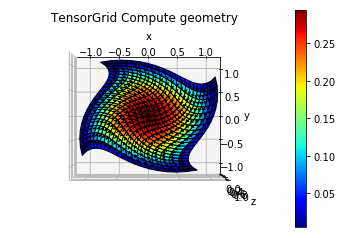

In [13]:
plot_grid.plot_grid(g, p, P0u, figsize=(12, 8))

### Hybrid-dual virtual element method
The hybrid-dual virtual element method solves the single-phase flow problem in the dual formulation. The pressure at each face is computed directly computed. The pressure and normal flux need to be computed a-posteriori.

In [14]:
from porepy.numerics.vem import hybrid

solver = hybrid.HybridDualVEM()
A, b = solver.matrix_rhs(g, data)
l = sps.linalg.spsolve(A, b)                                              

# Perform local computation to compute the normal flux and pressure
u, p = solver.compute_up(g, l, data)

# For visualisation purpose project the flux on a vector piecewise constant field
P0u = dual.DualVEM().project_u(g, u)

To represent the solution: pressure and velocity.

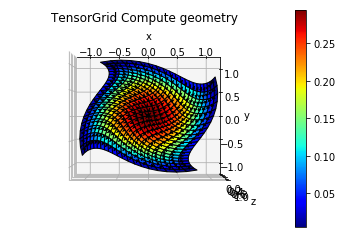

In [15]:
plot_grid.plot_grid(g, p, P0u, figsize=(12, 8))